<a href="https://colab.research.google.com/github/mamenaca/curso_python/blob/main/modelo_taxis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PAQUETES REQUERIDOS

In [1]:
%%capture
!pip install ipympl


In [2]:
%matplotlib ipympl

In [3]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import copy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from itertools import cycle

In [4]:
%%capture
!pip install pmdarima


In [5]:
from pmdarima.arima import auto_arima
import datetime


In [6]:
from pmdarima.arima import ADFTest
from pmdarima import utils

In [7]:
#from google.colab import output
#output.enable_custom_widget_manager()

Guardar el archivo HV del taxi como xlsx

In [8]:
datos=pd.read_excel(r"Por_Taxi.xlsx",skiprows=(0,1,2,3,4,5,6,7,8,9,10))#10
datos["GASTOS"]=list(map(lambda x:str(x).replace("$",""),datos["GASTOS"]))
datos["GASTOS"]=list(map(lambda x:float(str(x).replace(".",""))/(1000**(str(x).count(".")-1)) if (str(x).count(".")>=1) else float(x) ,datos["GASTOS"]))
#datos=datos.replace(to_replace="00.000",value="00",regex=True)
#openpyxl
fin=datos[datos["COD"]=="TOTAL EGRESOS"].index.to_numpy().max()
datos1=copy.deepcopy(datos.iloc[0:fin,])
del datos
datos=copy.deepcopy(datos1)
#datos1
#pd.set_option('display.max_rows', None)
datos.head()


,COD,FECHA,PLACA,CANTIDAD,FACTURA,CONCEPTO,OBSERVACIÓN,VALOR UNITARIO,GASTOS
0,52939,2022-02-09,FXS804,1,CTA COBRO,Computadora,ANTENA Y ENLLAVE,600.000,600.0
1,1,2021-07-17,FXS804,1,NaN,Kit Embrague,BUJE TREN TRAS-ROTULAS-AXIALES-ABRAZ PLAST-TER...,581.437,581437.0
2,1,2021-11-08,FXS804,1,1928,Sacada Golpe,"costilla izq, hechura costilla izq, sacada gol...",500.000,500.0
3,1,2022-03-14,FXS804,1,1529,Pintura guardabarro delantero izquierdo,"RETOQUE PUERTA DELANTERO IZQ,PUERTA TRASERA IZ...",485.000,485.0
4,1,2022-05-09,FXS804,1,TCFE1933,Guardafango,NaN,476.000,476.0


In [9]:
datos["FECHA"]=pd.to_datetime(datos["FECHA"],format="%d/%m/%Y")
#datos["Fecha_monitoreo"]=pd.to_datetime(datos["Fecha_monitoreo"],format="%d/%m/%Y")
datos["FECHA"][0]
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   COD             386 non-null    object        
 1   FECHA           386 non-null    datetime64[ns]
 2   PLACA           386 non-null    object        
 3   CANTIDAD        386 non-null    object        
 4   FACTURA         260 non-null    object        
 5   CONCEPTO        386 non-null    object        
 6   OBSERVACIÓN     196 non-null    object        
 7   VALOR UNITARIO  386 non-null    float64       
 8   GASTOS          386 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 27.3+ KB


In [10]:
datos_gas=copy.deepcopy(datos.groupby("FECHA").agg({"GASTOS":"sum"}))

In [11]:
datos_ing=pd.read_excel(r"Entregas_Diarias.xlsx",skiprows=(0,1,2,3)).fillna(0)
datos_ing1=copy.deepcopy(datos_ing.transpose().reset_index())
datos_ing1.head()

,index,0,1,2
0,Unnamed: 0,PLACA,FXS804,TOTAL(1)
1,Unnamed: 1,TURNO,L,0
2,Unnamed: 2,2020-10-08 00:00:00,0,0
3,Unnamed: 3,2020-10-09 00:00:00,0,0
4,Unnamed: 4,2020-10-10 00:00:00,40,40


In [12]:
datos_ing=pd.read_excel(r"Entregas_Diarias.xlsx",skiprows=(0,1,2,3,4))#4
datos_ing1=copy.deepcopy(datos_ing.transpose().reset_index())
del datos_ing

fin1=datos_ing1[datos_ing1["index"]=="TOTAL"].index.to_numpy().max()
datos_ing=copy.deepcopy(datos_ing1[2:fin1])
del datos_ing1


In [13]:
datos_ing.keys()

Index(['index', 0, 1], dtype='object')

In [14]:
datos_ing.columns

Index(['index', 0, 1], dtype='object')

In [15]:
total_correg=datos_ing.columns[len(datos_ing.columns)-1]#-1
datos_ingre=copy.deepcopy(datos_ing.groupby("index").agg({total_correg:"sum"}))

In [16]:
datos_ingre["gastos"]=datos_gas["GASTOS"]
ingre_gas=copy.deepcopy(datos_ingre.fillna(0))
del datos_ingre


In [17]:
ingre_gas.columns=["ingresos","gastos"]
ingre_gas.head()

,ingresos,gastos
index,,
2020-10-08,0.0,0.0
2020-10-09,0.0,0.0
2020-10-10,40.0,0.0
2020-10-11,60.0,20.0
2020-10-12,60.0,0.0


#Primer criterio: Tendencia de los Ingresos vs Gastos

____________________________________________________________
**Descripción**: En esta sección se procesan los datos de ingresos y gastos, se les aplica una suma del histórico de cada uno, y se analiza con evidencia estadística si los Ingresos son lo suficientemente superiores a los gastos. 

Aunque es visible todo el código y las gráficas, al final de la sección se da la conclusión respecto a este primer criterio
____________________________________________________________

##Cálculos y gráficas

Datos crudos:

In [18]:
Y1=ingre_gas["ingresos"]
Y2=ingre_gas["gastos"]
Y2

index
2020-10-08        0.0
2020-10-09        0.0
2020-10-10        0.0
2020-10-11       20.0
2020-10-12        0.0
               ...   
2022-10-27        0.0
2022-10-28        0.0
2022-10-29    20003.0
2022-10-30        0.0
2022-10-31        0.0
Name: gastos, Length: 670, dtype: float64

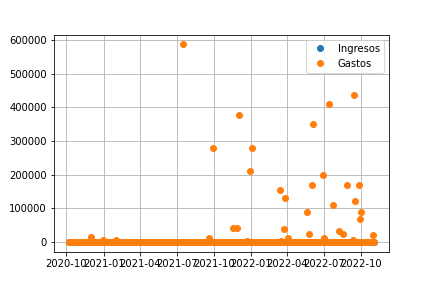

In [19]:
%matplotlib ipympl
X=ingre_gas.index
Y1=ingre_gas["ingresos"]
Y2=ingre_gas["gastos"]
plt.figure()
plt.plot_date(X,Y1,label="Ingresos")
plt.plot_date(X,Y2,label="Gastos")
plt.grid()
plt.legend(loc="best")
plt.show()

Ingresos y Gastos acumulados

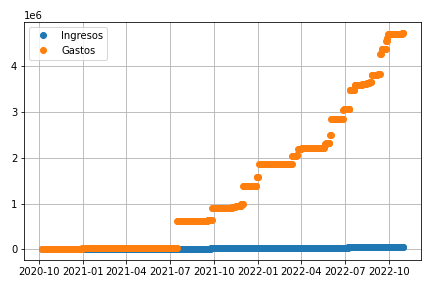

In [20]:
from google.colab import output
output.enable_custom_widget_manager()


X=ingre_gas.index
Y1=ingre_gas["ingresos"].cumsum()
Y2=ingre_gas["gastos"].cumsum()
plt.rcParams["figure.autolayout"] = True

def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))

fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)



plt.plot_date(X,Y1,label="Ingresos")
plt.plot_date(X,Y2,label="Gastos")
plt.grid()
plt.legend(loc="best")
plt.show()

In [21]:
ejeX1=ingre_gas.head(180).reset_index().index.to_numpy()*len(ingre_gas["ingresos"])/12
#ejeX1=matplotlib.dates.date2num(ejeXt[ejeXt==ejeXt])
ejeY1=pd.to_numeric(ingre_gas.head(180)["ingresos"].cumsum())
#ejeY=pd.to_numeric(ingre_gas["ingresos"])
X=ejeX1
del ejeX1
Y=ejeY1
del ejeY1
X=X[np.in1d(Y,Y[Y==Y])].reshape(-1,1)
Y=Y[Y==Y].values.reshape(-1,1)
X=sm.add_constant(X)
model1 = sm.OLS(Y, X).fit()
model1.summary()
(model1.params, model1.rsquared,model1.pvalues)
#np.arctan(model1.params[1])*180/np.pi

(array([-338.2771639 ,    1.23232762]),
 0.9965508871331707,
 array([3.71162735e-021, 4.29359584e-221]))

In [22]:
ejeX2=ingre_gas.head(180).reset_index().index.to_numpy()*len(ingre_gas["ingresos"])/12
#ejeX2=matplotlib.dates.date2num(ejeXt[ejeXt==ejeXt])
ejeY2=pd.to_numeric(ingre_gas.head(180)["gastos"].cumsum())
#ejeY=pd.to_numeric(ingre_gas["ingresos"])
X=ejeX2
del ejeX2
Y=ejeY2
del ejeY2
X=X[np.in1d(Y,Y[Y==Y])].reshape(-1,1)
Y=Y[Y==Y].values.reshape(-1,1)
X=sm.add_constant(X)
model2 = sm.OLS(Y, X).fit()
model2.summary()
(model2.params, model2.rsquared,model2.pvalues)
#np.arctan(model2.params[1])*180/np.pi

(array([-139.60982198,    3.54807946]),
 0.8484094217284317,
 array([8.30063873e-01, 7.78419968e-75]))

##Resultado:

In [24]:
ang=np.arctan(model1.params[1])*180/np.pi-np.arctan(model2.params[1])*180/np.pi
criterios=[]
if ang >7 and model2.pvalues[1]<0.05 and model1.pvalues[1]<0.05:
  criterios.append("VERDE")
  print(f"El ángulo formado por ingresos y egresos es de {np.round(ang,2)} grados y, tiene evidencia \n estadística mayor al 95% de seguir acrecentando la diferencia")
else:
  if ang >=5 and ang <=7:
    criterios.append("AMARILLO")
    print("El ángulo formado por ingresos y egresos tiene evidencia \n mayor al 95% de estar riesgosamente cerrado")
  else:
    criterios.append("AMARILLO")
    print("El ángulo formado por ingresos y egresos tiene evidencia \n mayor al 95% de ser muy cercano a cero")


El ángulo formado por ingresos y egresos tiene evidencia 
 mayor al 95% de ser muy cercano a cero


# Segundo Criterio: Predicciones con model de series de tiempo SARIMA

____________________________________________________________
**Descripción**: Se modela aquí el VPN (que es la ganancia neta que tiene en cuenta la devaluación del dinero), con un modelo de series de tiempo del tipo SARIMA. Se usa este tipo de modelo por el excelente ajuste que tiene para datos que varían en el tiempo especialmente cuando se tiene basta disponibilidad de datos. El modelo entregará predicciones con viabilidad estadística respecto a las próximas ganancias (9 semanas) del vehículo.
____________________________________________________________

##Cálculos y gráficas

Prueba de estacionareidad:

In [25]:
inversion=0#200000 #200 millones, porque todo está dividido en 1000
ti=0.03333333/100 #tasa de interés TED, equivaltente a 12% EA para taxis en COL
n=ingre_gas.reset_index().index
ingre_gas["Fi"]=(ingre_gas["ingresos"]-ingre_gas["gastos"])/((1+ti)**n)
ingre_gas["Fi"][0]=ingre_gas["Fi"][0]-inversion
ingre_gas["vpn"]=ingre_gas["Fi"].cumsum()
ingre_gas_vpn=copy.deepcopy(ingre_gas)
del ingre_gas
ingre_gas_vpn.head()


,ingresos,gastos,Fi,vpn
index,,,,
2020-10-08,0.0,0.0,0.000000,0.000000
2020-10-09,0.0,0.0,0.000000,0.000000
2020-10-10,40.0,0.0,39.973347,39.973347
2020-10-11,60.0,20.0,39.960027,79.933373
2020-10-12,60.0,0.0,59.920067,139.853440


In [26]:
ingre_gas_vpn.head()

,ingresos,gastos,Fi,vpn
index,,,,
2020-10-08,0.0,0.0,0.000000,0.000000
2020-10-09,0.0,0.0,0.000000,0.000000
2020-10-10,40.0,0.0,39.973347,39.973347
2020-10-11,60.0,20.0,39.960027,79.933373
2020-10-12,60.0,0.0,59.920067,139.853440


In [27]:
dias_mod=360

adf=ADFTest(alpha=0.5)

delta_dia=7

datos=copy.deepcopy(ingre_gas_vpn.iloc[list(np.arange(0,len(ingre_gas_vpn[["vpn"]])+1,delta_dia))].tail(dias_mod)[["vpn"]])#"vpn"]])+1
result=adf.should_diff(datos)
result

(0.9706495727814002, True)

In [28]:

#with threadpool_limits(limits=1, user_api='blas'): #blas   you can use it for MKL also
modelo_arima=auto_arima(datos, start_p=0, d=None, start_q=0, max_p=5, max_d=5, 
          max_q=5, start_P=0, D=None, start_Q=0, max_P=5, max_D=5, max_Q=5, 
           m=52, seasonal=result[1],  
            n_jobs=-1, stepwise=True,
            suppress_warnings=True, 
             error_action='warn', trace=True, random_state=20, 
             n_fits=50)

/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=2523.096, Time=0.13 sec
 ARIMA(1,2,0)(1,0,0)[52]             : AIC=2495.293, Time=1.55 sec
 ARIMA(0,2,1)(0,0,1)[52]             : AIC=2463.996, Time=1.58 sec
 ARIMA(0,2,1)(0,0,0)[52]             : AIC=2462.118, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[52]             : AIC=2463.996, Time=1.86 sec
 ARIMA(0,2,1)(1,0,1)[52]             : AIC=2465.996, Time=2.17 sec
 ARIMA(1,2,1)(0,0,0)[52]             : AIC=2463.507, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[52]             : AIC=2463.477, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[52]             : AIC=2493.583, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[52]             : AIC=2463.073, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,2,1)(0,0,0)[52]          
Total fit time: 8.019 seconds


In [29]:
dias_pred=9 #<- SON SEMANAS
datos_predic_fut_X=modelo_arima.predict(n_periods=dias_pred)
datos_predic_fut_X.index


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RangeIndex(start=96, stop=105, step=1)

In [30]:
#datos_predic=pd.DataFrame()
#datos_predic.head()#.predict_in_sample(return_conf_int=True)
datos_predic=modelo_arima.fit(datos).predict_in_sample(return_conf_int=True)
             #modelo_arima.fit(datos).predict(dias_pred,return_conf_int=True)
            #modelo_arima.fit(datos).predict_in_sample(return_conf_int=True)

In [31]:

#datos_predic_fut=pd.DataFrame(modelo_arima.predict(dias_pred,return_conf_int=True))
                #index=pd.date_range(datos.index[len(datos.index)-1]
                #+datetime.timedelta(days = 1),periods=60,freq="d"))
diaF=datos.index[len(datos.index)-1]
datos_predic_fut_X.index=pd.to_datetime(pd.date_range(datos.index[len(datos.index)-1]
                +datetime.timedelta(days = 1),periods=dias_pred,freq="w"))
datos_predic_fut_Y=modelo_arima.fit(datos).predict(dias_pred,return_conf_int=True)
#datos_predic_fut.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


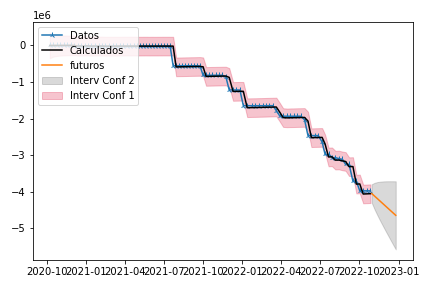

In [32]:
corr=0
plt.rcParams["figure.autolayout"] = True

def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))

fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)



plt.plot(datos.tail(dias_mod-corr),label="Datos",marker="2")
plt.plot(datos_predic[0].tail(dias_mod-corr),label="Calculados",color="k")
plt.plot(datos_predic_fut_X,label="futuros")

plt.fill_between(datos_predic_fut_X.index,
                datos_predic_fut_Y[1][:,0],
                datos_predic_fut_Y[1][:,1],
                color="k",alpha=0.15,label="Interv Conf 2")
plt.fill_between(datos_predic[0].tail(dias_mod-corr).index,
                datos_predic[1][-dias_mod-corr-1:len(datos_predic[0].tail(dias_mod-corr).index)+1][:,0],
                datos_predic[1][-dias_mod-corr-1:len(datos_predic[0].tail(dias_mod-corr).index)+1][:,1],
                color="crimson",alpha=0.25,label="Interv Conf 1")
plt.legend(loc="upper left")
plt.show()

In [33]:
modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1229.059
Date:                Sun, 11 Dec 2022   AIC                           2462.118
Time:                        00:36:16   BIC                           2467.204
Sample:                             0   HQIC                          2464.172
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9476      0.063    -15.016      0.000      -1.071      -0.824
sigma2       1.69e+10    1.3e-12    1.3e+22      0.000    1.69e+10    1.69e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               376.60
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):            2043.13   Skew:                            -2.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+37. Standard errors may be unstable.
"""

##Resultado:

In [34]:
yuy=np.round(sum(sum(datos_predic[1]<datos.loc[diaF].values))*100/sum(sum(datos_predic[1]*0+1)),2)
print(f"Hay {yuy}% de probabilidad de aumento de \n las ganancias netas en los próximos 2 meses")
if yuy>55:
  criterios.append("VERDE")
else:
  if yuy >=47 and yuy <=55:
    criterios.append("AMARILLO")
  else:
    criterios.append("ROJO")

Hay 2.6% de probabilidad de aumento de 
 las ganancias netas en los próximos 2 meses


# Tercer criterio: Ingresos-Gastos (VPN) vs kilometraje


____________________________________________________________
Descripción: Un supuesto razonable para un vehículo-taxi rentable, es que la ganancia sea proporcional al kilometraje, lo que es, que estas dos variables formen una línea recta. Así, un parámetro clave para el análisis de la factibilidad es el coeficiente R2, que da cuenta de qué tanto se puede explicar del VPN con el kilometraje, el R2 DEBE ser mayor a 0.9 para que se asegure que la ganancia (VPN) crezca con el kilometraje. Al final de esta sección está el resultado.
____________________________________________________________

##Cálculos y gráficas

In [35]:
%%capture
km=pd.read_excel(r"gps.xlsx",skiprows=(0,1,2,3,4),
                  parse_dates=["FECHA"],
date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%Y"), 
index_col="FECHA")
km.index=pd.to_datetime(pd.date_range(km.index[0],periods=len(km["PLACA"]),freq="d"))
km_n=copy.deepcopy(km.fillna(0))
del km
km_n
km=copy.deepcopy(km_n)
del km_n
#km

Gráfica VPN vs kilometraje

In [36]:

#plt.figure()

#plt.plot(km.index,km["KM_ACUMULADO"])
km["acum2"]=copy.deepcopy(km["KIL_DIA"])
km["km_dia"]=copy.deepcopy(km["KIL_DIA"])
km.loc[km.index[0],"acum2"]=copy.deepcopy(km["KM_ACUMULADO"][0])
km["acum2"]=copy.deepcopy(km["acum2"].cumsum())
#plt.plot(km["acum2"],km["vpn"])

#plt.show()

In [37]:
ingre_gas_vpn["km_acum"]=km["acum2"]
ingre_gas_vpn["km_dia"]=km["km_dia"]
ingre_gas_vpn_km=copy.deepcopy(ingre_gas_vpn.fillna(0))
del ingre_gas_vpn
ingre_gas_vpn_km.tail(5)

,ingresos,gastos,Fi,vpn,km_acum,km_dia
index,,,,,,
2022-10-27,72.0,0.0,57.687263,-3.972342e+06,164850.63,179.79
2022-10-28,110.0,0.0,88.103951,-3.972254e+06,164996.36,145.73
2022-10-29,110.0,20003.0,-15927.889787,-3.988182e+06,165167.98,171.62
2022-10-30,105.0,0.0,84.043188,-3.988098e+06,165326.05,158.07
2022-10-31,110.0,0.0,88.015906,-3.988010e+06,165333.15,7.10


Fecha en que se empiezan a tomar datos de km: (datos de ingresos hay desde 2020

In [38]:
fil=(ingre_gas_vpn_km["km_acum"]>0) & (ingre_gas_vpn_km["ingresos"]>0) & ingre_gas_vpn_km["gastos"]>0
ingre_gas_vpn_km[fil].index[0]

Timestamp('2021-01-02 00:00:00')

Gráfica KM vs fechas 


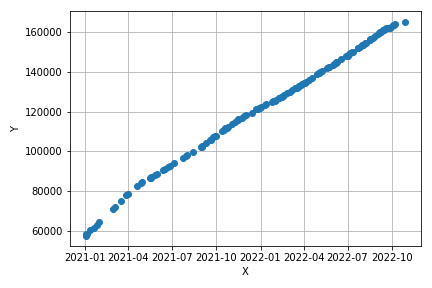

In [39]:
X=ingre_gas_vpn_km[fil].index
Y3=ingre_gas_vpn_km[fil]["km_acum"]

plt.figure()
plt.plot_date(X,Y3)
plt.grid()
#plt.legend(loc="best")
#plt.figure(figsize=(8, 6), dpi=180)
plt.xlabel("X")
plt.ylabel("Y")
#plt.savefig("grafica_vpn.pdf")
print("Gráfica KM vs fechas ")
plt.show()

In [40]:
np.mean(np.diff(Y3))#/(np.diff(Y3)+1e-2))

806.7626315789472

In [41]:
diasINT=[]
for i in range(len(X)-1):
  gggd=X[1+i]-X[0+i]
  diasINT.append(gggd.days)
np.mean(diasINT)

5.0

In [42]:
ejeX=ingre_gas_vpn_km[fil]["km_acum"].values
####ejeX=matplotlib.dates.date2num(ejeX[ejeX==ejeX])
ejeY=pd.to_numeric(ingre_gas_vpn_km[fil]["vpn"])
#ejeY=pd.to_numeric(ingre_gas_vpn_km[fil]["ingresos"])
X=ejeX
del ejeX
Y=ejeY
del ejeY
X=X[np.in1d(Y,Y[Y==Y])].reshape(-1,1)
Y=Y[Y==Y].values.reshape(-1,1)
X=sm.add_constant(X)
model = sm.OLS(Y, X).fit()


In [43]:
(model.params, model.rsquared,model.pvalues)

(array([ 3.36504054e+06, -4.04968928e+01]),
 0.9093023788318142,
 array([2.40255471e-49, 1.15473651e-70]))

Intervalos de confianza de la regresión:

In [44]:
st, data, ss2 = summary_table(model, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

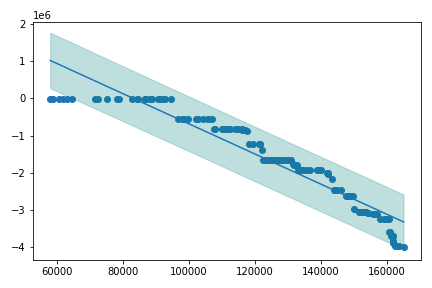

In [45]:
#plt.figure()


#plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))

fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)



plt.plot(X[:,1],model.predict(X))

plt.scatter(X[:,1],Y)

plt.fill_between(X[:,1],
                predict_ci_low,
                predict_ci_upp,
                color="teal",alpha=0.25)

#plt.fill_between(X[:,1],
#                predict_mean_ci_low,
#                predict_mean_ci_upp,
#                color="r",alpha=0.35)
#print("Datos y REGRESIÓN vpn vs kilometraje")
plt.show()



In [46]:
np.mean((np.diff(model.predict(X)))/(np.diff(X[:,1])+1e-2))

-40.18070316260605

In [47]:
(model.predict(X)).min()

-3323749.430944508

In [48]:
pd.set_option("display.max_rows", None)
#ingre_gas_vpn_km[fil]


##Resultado:

In [50]:
#ingre_gas_vpn_km[fil].to_csv(r"/content/tabla_vpn_km.csv",encoding='utf-8-sig')
if model.rsquared <0.9:
  if model.rsquared >=0.7 and model.rsquared<0.9:
    criterios.append("AMARILLO")
    print(f"El valor del coef R2 es de {model.rsquared} y por tanto, hay evidencia para saber que los últimos valores de la anterior gráfica decrecen")
  else:
    criterios.append("ROJO")
    print(f"El valor del coef R2 es de {model.rsquared} y por tanto, hay evidencia para saber que los últimos valores de la anterior gráfica decrecen fuertemente")
else:
  criterios.append("VERDE")
  print(f"Hay fuerte evidencia de que el VPN sigue aumentando con el kilometraje,\n la ganancia acumulada (VPN) aumenta {np.round(1000*model.params[1],2)} $/km_acum aprox.\n Se puede verificar esta afirmación con la gráfica\n y los Intervalos de confianza calculados al 95% ")

Hay fuerte evidencia de que el VPN sigue aumentando con el kilometraje,
 la ganancia acumulada (VPN) aumenta -40496.89 $/km_acum aprox.
 Se puede verificar esta afirmación con la gráfica
 y los Intervalos de confianza calculados al 95% 


###**Estimación de ganancias a partir con el kilometraje**
# (opcional, para leer la gráfica anterior):

Ingrese el kilometraje del vehículo en la siguiente celda:

In [51]:
kilom=125000

In [52]:

moneda="{:,}".format(np.round((kilom*model.params[1]+model.params[0])*1000,2))
print(f"El valor esperado de ganancia acumulada TOTAL,\n con un kilometraje de {kilom}, es:  ${moneda}")

El valor esperado de ganancia acumulada TOTAL,
 con un kilometraje de 125000, es:  $-1,697,071,052.22


In [53]:
#pd.set_option("display.max_rows", None)


#Cuarto Criterio: Relación Ganancia_Acum/kilometraje 

Se trata de un criterio flexible que, en el mejor de los casos, debe dar VERDE, lo que significaría que en proporción, aumenta más rápido la ganancia que el kilometraje. En otras palabras, se tarda menos en acumular ganancia con base en los kilómetros recorridos (no necesariamente en tiempo)

No es un criterio de que el vehículo no sea rentable, sino de cuán rápido aumenta su ganancia con cada kilómetro

____________________________________________________________
**Descripción**: Si se piensa en un índice que dé cuenta de la rentabilidad de un vehículo, el más intuitivo puede ser VPN/kilometraje, porque, el punto deseable es que este índice deba ser máximo y creciente, es decir, el mejor escenario es tener la mayor ganancia con el menor gasto del kilometraje. Se calcula este índice para los últimos 8 meses y se espera que sea creciente en el tiempo.


____________________________________________________________

##Cálculos y gráficos

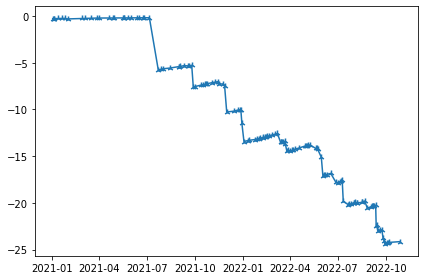

In [54]:
#from google.colab import output
#output.disable_custom_widget_manager()
#plt.figure()
%matplotlib inline
plt.plot(ingre_gas_vpn_km[fil].index,(ingre_gas_vpn_km[fil]["vpn"]/ingre_gas_vpn_km[fil]["km_acum"]))
#pd.DataFrame(list(zip(Y,X[:,1])),columns =['vpn', 'kilometraje']).to_csv(r"/content/tabla_vpn_km.csv",encoding='utf-8-sig')

plt.scatter(ingre_gas_vpn_km[fil].index,Y.reshape(-1)/X[:,1],marker="2")
plt.show()

In [55]:
#plt.plot(np.diff(X[:,1]))

In [56]:
#plt.plot(np.diff(Y.reshape(-1)))

In [57]:

df = pd.DataFrame(list(zip(Y,X[:,1])),
               columns =['vpn', 'kilometraje'])
#df.sort_values(by="Frecuencia",ascending=False).head(10)

In [58]:
ingre_gas_vpn_km#[(ingre_gas_vpn_km.index[-1]-datetime.timedelta(61))]
a=ingre_gas_vpn_km.iloc[[ -1 ]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1]]["km_acum"]
jj=30
b=ingre_gas_vpn_km.iloc[[ -1 -jj]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1-jj]]["km_acum"]
c=ingre_gas_vpn_km.iloc[[ -1 -jj*2]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1-jj*2]]["km_acum"]
d=ingre_gas_vpn_km.iloc[[ -1 -jj*4]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1-jj*4]]["km_acum"]
e=ingre_gas_vpn_km.iloc[[ -1 -jj*6]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1-jj*6]]["km_acum"]
f=ingre_gas_vpn_km.iloc[[ -1 -jj*8]]["vpn"]/ingre_gas_vpn_km.iloc[[ -1-jj*8]]["km_acum"]
if a.values.item()> b.values.item()> c.values.item()> d.values.item()> e.values.item()> f.values.item():
  criterios.append("VERDE")
  p1="El vehículo se encuentra en fase rentable, pues él índice \n VPN/km viene creciendo hace 8 meses hasta hoy "
else:
  if a.values.item()> b.values.item()> c.values.item():
    criterios.append("AMARILLO")
    p1="El vehículo presenta mucha incertidumbre respecto a la rentabilidad"
  else:
    criterios.append("ROJO")
    p1="El vehículo presenta mucha incertidumbre respecto a la rentabilidad"


##Resultado

In [59]:
print(p1)

El vehículo presenta mucha incertidumbre respecto a la rentabilidad


#RESUMEN de los Criterios:

In [60]:
criterios

['AMARILLO', 'ROJO', 'VERDE', 'ROJO']

#Diagnóstico de los Gastos

In [61]:
datos1.head()

,COD,FECHA,PLACA,CANTIDAD,FACTURA,CONCEPTO,OBSERVACIÓN,VALOR UNITARIO,GASTOS
0,52939,2022-02-09,FXS804,1,CTA COBRO,Computadora,ANTENA Y ENLLAVE,600.000,600.0
1,1,2021-07-17,FXS804,1,NaN,Kit Embrague,BUJE TREN TRAS-ROTULAS-AXIALES-ABRAZ PLAST-TER...,581.437,581437.0
2,1,2021-11-08,FXS804,1,1928,Sacada Golpe,"costilla izq, hechura costilla izq, sacada gol...",500.000,500.0
3,1,2022-03-14,FXS804,1,1529,Pintura guardabarro delantero izquierdo,"RETOQUE PUERTA DELANTERO IZQ,PUERTA TRASERA IZ...",485.000,485.0
4,1,2022-05-09,FXS804,1,TCFE1933,Guardafango,NaN,476.000,476.0


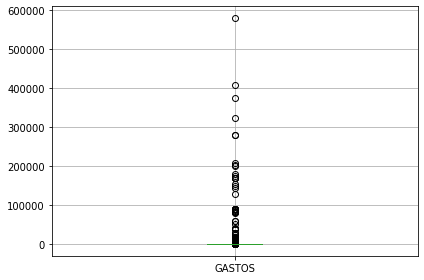

In [62]:
datos1["GASTOS"]=pd.to_numeric(datos1["GASTOS"])
hh=datos1[["GASTOS"]].boxplot()

In [63]:
gg=datos1[["GASTOS"]].describe()
gg

,GASTOS
count,386.000000
mean,16216.476684
std,58332.592418
min,2.000000
25%,25.250000
50%,45.500000
75%,240.000000
max,581437.000000


Se quitan los gastos administrativos y de impuestos para analizar los GASTOS extremos

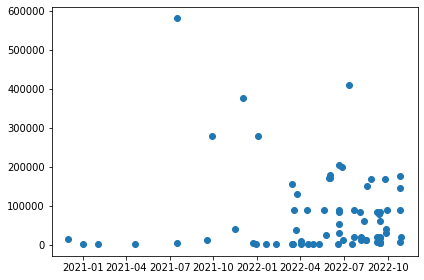

In [64]:
FILTRO=datos1["GASTOS"]>gg["GASTOS"][6]+(gg["GASTOS"][6]-gg["GASTOS"][4])*1.5
#datos[FILTRO][["CONCEPTO","CANTIDAD","OBSERVACIÓN"]]
filt2=np.array(list(map(lambda x:any( xx in x.lower() for xx in ["admin","impu","soat","tecnomec","dalmaru"]),datos1[FILTRO]["CONCEPTO"])))==False

plt.figure()
nuevo=copy.deepcopy(datos1[FILTRO][filt2]).sort_values(by="FECHA")
plt.scatter(nuevo["FECHA"],nuevo["GASTOS"])

plt.show()

Se agrupan los gastos por bloques de 3 gastos (no siempre 3 días) para analizar la frecuencia con la que se vienen haciendo gastos fuertes. Luego se presentan estos datos en tabla

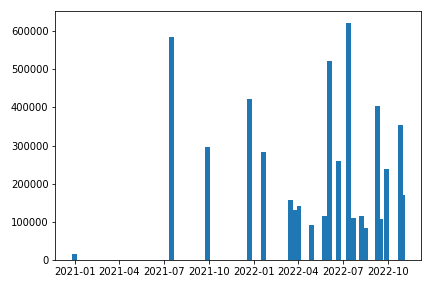

In [65]:
%matplotlib ipympl
i = iter(list(np.linspace(1,500,500)//3))
#i=iter(list(map(lambda x: str(int(x)),np.linspace(1,500,500)//3)))
nuevo['temporal'] = nuevo.index.map(dict(zip(nuevo.index, cycle(i))))

plt.figure()

plt.bar(nuevo.groupby("temporal").agg({"GASTOS":sum,"FECHA":max})["FECHA"],nuevo.groupby("temporal").agg({"GASTOS":sum,"FECHA":max})["GASTOS"] ,width=10 )

plt.show()

Datos anteriores en Tabla: 

In [66]:
tp=nuevo[["CONCEPTO"]]+" "
nuevo["CONCEPTO"]=nuevo["CONCEPTO"]+"--"
nuevo.groupby("temporal").agg({"GASTOS":sum,"FECHA":(min,max),"CONCEPTO":sum})

GASTOS      FECHA             \
               sum        min        max   
temporal                                   
0.0        15320.0 2020-12-01 2020-12-31   
1.0       584478.0 2021-01-31 2021-07-17   
2.0       296063.0 2021-07-17 2021-09-28   
3.0       420555.0 2021-11-16 2021-12-23   
4.0       282062.0 2021-12-30 2022-01-20   
5.0       157567.0 2022-02-09 2022-03-15   
6.0       130272.0 2022-03-17 2022-03-23   
7.0       141233.0 2022-03-26 2022-04-02   
8.0        92289.0 2022-04-14 2022-04-28   
9.0       116883.0 2022-05-11 2022-05-24   
10.0      519997.0 2022-05-31 2022-06-03   
11.0      258682.0 2022-06-18 2022-06-21   
12.0      202997.0 2022-06-21 2022-06-21   
13.0      621573.0 2022-06-28 2022-07-12   
14.0      111683.0 2022-07-18 2022-07-22   
15.0      114997.0 2022-08-05 2022-08-07   
16.0       83997.0 2022-08-12 2022-08-16   
17.0      404306.0 2022-08-19 2022-09-08   
18.0       43484.0 2022-09-08 2022-09-13   
19.0      104046.0 2022-09-13 2022-09-15   
20.0       79995.0 2022-09-15 2022-09-16   
21.0      106994.0 2022-09-16 2022-09-16   
22.0      239481.0 2022-09-26 2022-09-28   
23.0      354641.0 2022-09-30 2022-10-26   
24.0      171455.0 2022-10-26 2022-10-29   

                                                   CONCEPTO  
                                                        sum  
temporal                                                     
0.0                            Batería--Tarjeta Operación--  
1.0       Traspaso--Seguridad Social Conductor--Kit Embr...  
2.0       Cremallera--Guardapolvo Botella Dirección--Kit...  
3.0       Buje Barra Estabilizadora--Tarjeta Operación--...  
4.0       Seguridad Social Conductor--Kit Embrague--Segu...  
5.0       Computadora--COMPRA DE LLANTAS--Amortiguador T...  
6.0       Seguridad Social Conductor--Cambio Aceite Moto...  
7.0           Brazos Axiales--Fuelle--Abrazadera Plástica--  
8.0       Cambio Aceite Motor, Filtro Aceite y Filtro--S...  
9.0       Seguridad Social Conductor--Cambio Aceite Moto...  
10.0      Bobina Ignición--COMPRA DE LLANTAS--Bobina Ign...  
11.0      Seguridad Social Conductor--Aceite Caja--COMPR...  
12.0      Tijera--Cambio Aceite Motor, Filtro Aceite y F...  
13.0       Batería--Filtro De Gasolina--COMPRA DE LLANTAS--  
14.0      Seguridad Social Conductor--Líquido Frenos--Ca...  
15.0            Tijera--Bombillo Halógeno--Líquido Frenos--  
16.0         Pastillas--Bombillo Halógeno--fusible 30 amp--  
17.0      Brazo Tensor--Seguridad Social Conductor--Bomb...  
18.0      Conector--Certificados--Desvinculación Coopera...  
19.0      Tarjeta Operación--Vinculación Cooperativa--Bo...  
20.0      bombillo lagrima--Manilla Externa Puerta Delan...  
21.0           Tijera--Abrazadera Plástica--Balinera 6203--  
22.0      Seguridad Social Conductor--Pito--Terminal Dir...  
23.0      Cambio Aceite Motor, Filtro Aceite y Filtro--C...  
24.0                        Varilla--Automático--Gasolina--

In [67]:
print("\n DETALLE DE LOS GASTOS ANTERIORES: \n")
print(*list(nuevo.groupby("temporal").agg({"GASTOS":sum,"FECHA":(min,max),"CONCEPTO":sum})["CONCEPTO"]["sum"]), sep = "\n")#[0]



 DETALLE DE LOS GASTOS ANTERIORES: 

Batería--Tarjeta Operación--
Traspaso--Seguridad Social Conductor--Kit Embrague--
Cremallera--Guardapolvo Botella Dirección--Kit Embrague--
Buje Barra Estabilizadora--Tarjeta Operación--Guaya Clutch--
Seguridad Social Conductor--Kit Embrague--Seguridad Social Conductor--
Computadora--COMPRA DE LLANTAS--Amortiguador Trasero--
Seguridad Social Conductor--Cambio Aceite Motor, Filtro Aceite y Filtro--Tijera--
Brazos Axiales--Fuelle--Abrazadera Plástica--
Cambio Aceite Motor, Filtro Aceite y Filtro--Seguridad Social Conductor--Terminal Axial--
Seguridad Social Conductor--Cambio Aceite Motor, Filtro Aceite y Filtro--Marquesina--
Bobina Ignición--COMPRA DE LLANTAS--Bobina Ignición--
Seguridad Social Conductor--Aceite Caja--COMPRA DE LLANTAS--
Tijera--Cambio Aceite Motor, Filtro Aceite y Filtro--Filtro Aire--
Batería--Filtro De Gasolina--COMPRA DE LLANTAS--
Seguridad Social Conductor--Líquido Frenos--Cambio Aceite Motor, Filtro Aceite y Filtro--
Tijera--Bo

Con el trabajo a la anterior información es posible analizar la frecuencia con la que se aplican los diferentes gastos que son atípicamente altos. 

In [68]:
sali=tp["CONCEPTO"].sum()

In [69]:
# Python code to find frequency of each word
def freq(str):
 
    # break the string into list of words
    str = str.split()        
    str2 = []
 
    # loop till string values present in list str
    for i in str:            
 
        # checking for the duplicacy
        if i not in str2:
 
            # insert value in str2
            str2.append(i)
    temp=[]
    tempstr=[]
    for i in range(0, len(str2)):
          if str2[i]!="de" and str2[i]!="con"and str2[i]!= "a" and str2[i]!="en"and str2[i]!="por"and str2[i]!="y"and any(xx in str2[i] for xx in ["kit"])!=True:
            # count the frequency of each word(present
            # in str2) in str and print
            #print('Frequency of', str2[i], 'is :', str.count(str2[i]))
            temp.append(str.count(str2[i]))
            tempstr.append(str2[i])
    return (tempstr,temp)
 
def main():
    str =sali.lower()
    (a,b)=freq(str)                   
    return (a,b)
 
if __name__=="__main__":
    main()             # call main function

In [70]:
ffr="asdasdalkitmaru"
any(xx in ffr for xx in ["kit"])

True

In [71]:
#any( xx in x.lower() for xx in ["admin","impu","soat","tecnomec"])
palab,frc=main()
palab,frc
df = pd.DataFrame(list(zip(palab, frc)),
               columns =['Palabras', 'Frecuencia'])
df.sort_values(by="Frecuencia",ascending=False).head(10)

,Palabras,Frecuencia
25,filtro,14
23,aceite,13
4,seguridad,10
5,social,10
6,conductor,10
24,"motor,",6
22,cambio,6
26,tijera,4
19,llantas,4
42,bombillo,4


#Herramienta para calcular la rentabilidad de un nuevo vehículo

__________________________________________________________
El presente aplicativo en una proyección financiera con base en los parámetros calculados y encontrados para los vehículos tipo Taxi analizados. Se trata de una herramienta de pronóstico a priori qu usa parámetros conservadores, evitando así optimismo infundado. 
_________________________________________________________

In [72]:
inversion_ini=60000
costo_cancel_chatarr=1500

In [76]:
def ganancia(anios_proyec=7,inversion_ini=60000,costo_cancel_chatarr=1500):
  anio=np.linspace(0,anios_proyec,365*anios_proyec-1)
  noise = np.random.normal(0,1,365*anios_proyec-1)
  dias_a=anio*365
  km_a=161*dias_a#+noise*3000
  vpn=0.160*km_a#-inversion_ini
  ceri=np.zeros(int(np.ceil((365*anios_proyec-1)/2)))
  ceriT=np.zeros(int(np.floor((365*anios_proyec-1)/2)))
  vpn[int(len(ceriT)):365*anios_proyec ]   =vpn[int(len(ceriT)):365*anios_proyec ]/(1+np.exp(ceri))+vpn[int(len(ceriT))]*0.5
  vpn[-1]=vpn[-1]-costo_cancel_chatarr*1.05**anios_proyec
  vpn=vpn+200*noise
  deprec=-inversion_ini*0.1+np.linspace(start=inversion_ini,stop=0.45*inversion_ini,num=365*anios_proyec-1)
  return deprec,vpn,anio
deprec,vpn,anio=ganancia(inversion_ini=inversion_ini,costo_cancel_chatarr=costo_cancel_chatarr)

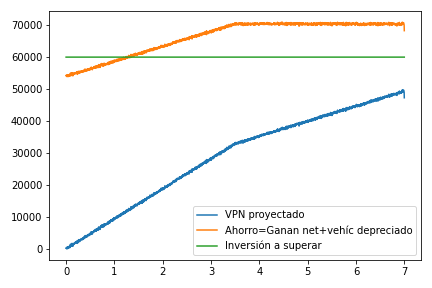

In [77]:
#%matplotlib inline
#output.disable_custom_widget_manager()
plt.figure()

plt.plot(anio,vpn,label="VPN proyectado")
plt.plot(anio,vpn+deprec,label="Ahorro=Ganan net+vehíc depreciado")
plt.plot(anio,np.array(vpn+deprec)*0+inversion_ini,label="Inversión a superar")
plt.legend(loc="best")
plt.show()

In [75]:
tiempo_a_liquidar= 5   #-----AÑOS---
deprec,vpn,anio=ganancia(inversion_ini=inversion_ini,costo_cancel_chatarr=costo_cancel_chatarr)
GANANCIA_NETA_TOTAL=vpn[-1]+deprec[-1]-inversion_ini-costo_cancel_chatarr
monedaF="{:,}".format(np.round(GANANCIA_NETA_TOTAL*1000,2))
print(f"La GANANCIA_NETA_TOTAL es de ${monedaF}, si vende a los {tiempo_a_liquidar} años")

La GANANCIA_NETA_TOTAL es de $1,095,234.6, si vende a los 5 años
